In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from skspatial.objects import LineSegment, Line, Vector

# some helper functions
from helpers import (
    get_arc_point,
    draw_arc,
    rotate,
    translate,
    flip_y,
    flip_x,
    optimize_points,
    chaikin,
    rotate_point,
    scale,
)
from pcb_json import (
    dump_json,
    plot_json,
    create_via,
    create_pad,
    create_pin,
    create_silk,
    create_mounting_hole,
)

from enum import Enum

Layer = Enum("Layer", "FRONT BACK")

In [3]:
# Track width and spacing
TRACK_WIDTH = 0.4 #0.102
TRACK_SPACING = 0.1 #0.2

# via defaults
VIA_DIAM = 0.4 #0.8
VIA_DRILL = 0.2 #0.4

# this is for a 1.27mm pitch pin
PIN_DIAM = 1.0
PIN_DRILL = 0.65

# this is for the PCB connector - see https://www.farnell.com/datasheets/2003059.pdf
PAD_ENABLE = False
PAD_WIDTH = 3
PAD_HEIGHT = 2
PAD_PITCH = 2.5

# Vias for connecting to the coils
COIL_INPUT_VIAS_ENABLE = True

# PCB edge cuts
PCB_EDGE_CUTS = True #false

# Stator hole
STATOR_HOLE_RADIUS = 50 #5.5

# Coil net name
COIL_NET_NAME = "coils"

In [4]:
# Large 35 mm version

# PCB Edge size
STATOR_RADIUS = 80

# where to puth the mounting pins
SCREW_HOLE_DRILL_DIAM = 2.3  # 2.3mm drill for a 2mm screw
SCREW_HOLE_RADIUS = STATOR_RADIUS

# Coil params
# for custom shape
TURNS = 8 #13
# for spiral
# TURNS = 17
COIL_CENTER_RADIUS = 65.00 #20.45
COIL_VIA_RADIUS = 65.00 #20.95

# Coil input vias
COIL_INPUT_VIA_RADIUS = 79 #78 #27

In [5]:
# LED ring
LED_RING_ENABLE = False
LED_RING_RADIUS = 32
LED_RING_VIA_OFFSET = 2.5
LED_RING_OUTER_VIA_RADIUS = LED_RING_RADIUS + LED_RING_VIA_OFFSET
LED_RING_INNER_VIA_RADIUS = LED_RING_RADIUS - LED_RING_VIA_OFFSET
LED_CHIP_PAD_RADIAL_FROM_CENTRE = 0.75
LED_CHIP_PAD_ANGLE_FROM_CENTRE = -1
LED_RING_NUM_LEDS = 60
LED_PAD_ANGLE_OFFSET = 1
LED_VPLUS_NET_NAME = "V+"
LED_GND_NET_NAME = "GND"
LED_IO_NET_NAME_BASE = "LED_IO_"
LED_IO_NET_NC = ""
LED_IO_NET_INPUT = "LED_RING_INPUT"
LED_POWER_TRACK_WIDTH = 1.5
LED_POWER_INTERCONN_TRACK_WIDTH = 0.5
LED_INTERCONN_TO_SUPPRESS = 58
LED_REF_BASE = "LED"
LED_RING_START_LED_REF = 38
LED_RING_END_LED_REF = 39

In [6]:
# where to put the input pads
INPUT_PAD_RADIUS = COIL_VIA_RADIUS
print(INPUT_PAD_RADIUS)

USE_SPIRAL = False

if USE_SPIRAL:
    TURNS = 18
    COIL_VIA_RADIUS = 20.5
    COIL_CENTER_RADIUS = 20.5

LAYERS = 4

OUTER_CONN_RADIUS = 79

65.0


# Arbitrary Coil Generation

In [7]:
# templates must be symmetric around the X axis and must include the center points on both size (e.g. (X1, 0).... (X2, 0) )
# template must also be convex
template = [
    (-8.5, 0),
    (-8.5, -0.45),
    (8.5, -2),
    (8.5, 0),
    (8.5, 2),
    (-8.5, 0.45),
    #original correct scale from CAD
    # (-12.5, 0),
    # (-12.5, -4.45),
    # (12.5, -6.5),
    # (12.5, 4.45),
    # (12.5, 6.5),
    # (-12.5, 1),

    # (-3.5, 0),
    # (-3.5, -0.01),
    # (1.9, -1.45),
    # (1.9, 0.0),
    # (1.9, 1.45),
    # (-3.5, 0.01),
    # Magnet is 5mm x 15mm

]

(-9.35, 9.35, -2.2, 2.2)

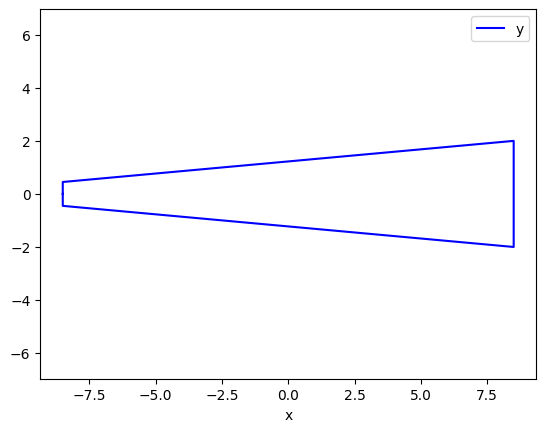

In [8]:
# plot the template shape wrapping around to the first point
df = pd.DataFrame(template + [template[0]], columns=["x", "y"])
ax = df.plot.line(x="x", y="y", color="blue")
ax.axis("equal")

In [9]:
def calculate_point(point, point1, point2, spacing, turn):
    reference_vector = Vector([-100, 0])
    angle = np.rad2deg(Vector(point).angle_between(reference_vector))
    if point[1] > 0:
        angle = 360 - angle
    vector = Vector(point1) - Vector(point2)
    normal = vector / np.linalg.norm(vector)
    # rotate the vector 90 degrees
    normal = np.array([-normal[1], normal[0]])
    # move the  point along the normal vector by the spacing
    offset = spacing * (turn * 360 + angle) / 360
    coil_point = point + normal * offset
    return (coil_point[0], coil_point[1])


def get_points(template, turns, spacing):
    coil_points = []
    reference_vector = Vector([-100, 0])
    template_index = 0
    template_length = len(template)
    for turn in range(turns * template_length):
        point1 = template[template_index % template_length]
        point2 = template[(template_index + 1) % template_length]

        # calculate the new positions of the points
        coil_point1 = calculate_point(
            point1, point1, point2, spacing, template_index // template_length
        )
        coil_point2 = calculate_point(
            point2, point1, point2, spacing, (template_index + 1) // template_length
        )
        # adjust the previous point so that the previous line intersects with this new line
        # this prevents any cutting of corners
        if len(coil_points) >= 2:
            # create a line from the previous two points
            line1 = Line(
                coil_points[len(coil_points) - 2],
                np.array(coil_points[len(coil_points) - 1])
                - np.array(coil_points[len(coil_points) - 2]),
            )
            # create a line from the two new points
            line2 = Line(
                np.array(coil_point1),
                np.array(np.array(coil_point1) - np.array(coil_point2)),
            )
            # find the intersection of the two lines
            try:
                intersection = line1.intersect_line(line2)
                # replace the previous point with the intersection
                coil_points[len(coil_points) - 1] = intersection
                # add the new point
                coil_points.append(coil_point2)
            except:
                # the lines did not intersect so just add the points
                coil_points.append(coil_point1)
                coil_points.append(coil_point2)
        else:
            coil_points.append(coil_point1)
            coil_points.append(coil_point2)

        template_index = template_index + 1
    return coil_points

In [10]:
def get_spiral(turns, start_radius, thickness, layer=Layer.FRONT):
    points = []
    # create a starting point in the center
    for angle in np.arange(0, turns * 360, 1):
        radius = start_radius + thickness * angle / 360
        if layer == Layer.BACK:
            x = radius * np.cos(np.deg2rad(angle + 180))
            y = radius * np.sin(np.deg2rad(angle + 180))
            points.append((x, -y))
        else:
            x = radius * np.cos(np.deg2rad(angle))
            y = radius * np.sin(np.deg2rad(angle))
            points.append((x, y))
    return points

In [11]:
if not USE_SPIRAL:
    print("Not using spiral")
    template_f = []
    for i in range(len(template)):
        template_f.append(template[len(template) - i - len(template) // 2])
    template_f = flip_x(template_f)
    points_f = chaikin(
        optimize_points(
            flip_x(get_points(template_f, TURNS, TRACK_SPACING + TRACK_WIDTH))
        ),
        2,
    )
    points_b = chaikin(
        optimize_points(get_points(template, TURNS, TRACK_SPACING + TRACK_WIDTH)), 2
    )
else:
    print("Using spiral")
    points_f = get_spiral(
        TURNS, VIA_DIAM / 2 + TRACK_SPACING, TRACK_SPACING + TRACK_WIDTH, Layer.FRONT
    )
    points_b = get_spiral(
        TURNS, VIA_DIAM / 2 + TRACK_SPACING, TRACK_SPACING + TRACK_WIDTH, Layer.BACK
    )

    points_f = [(0, 0)] + points_f
    points_b = [(0, 0)] + points_b
    print("Track points", len(points_f), len(points_b))

Not using spiral
Optimised from 64 to 34 points
Optimised from 64 to 34 points


Track points 134 134


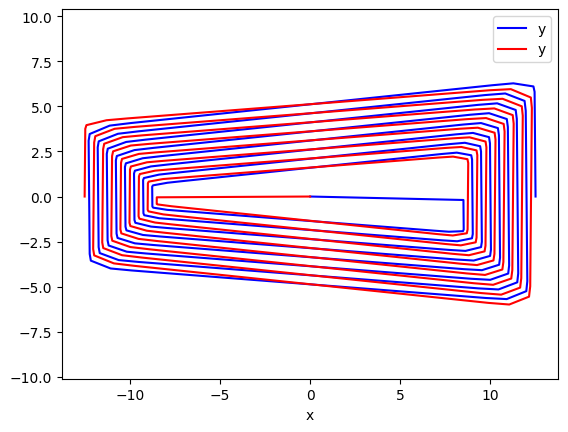

In [12]:
points_f = [(COIL_VIA_RADIUS - COIL_CENTER_RADIUS, 0)] + points_f
points_b = [(COIL_VIA_RADIUS - COIL_CENTER_RADIUS, 0)] + points_b

df = pd.DataFrame(points_f, columns=["x", "y"])
ax = df.plot.line(x="x", y="y", color="blue")
ax.axis("equal")
df = pd.DataFrame(points_b, columns=["x", "y"])
ax = df.plot.line(x="x", y="y", color="red", ax=ax)

print("Track points", len(points_f), len(points_b))

In [13]:
# write the coil out in a format that can be simulated
# rotate the points by 90 degrees so that the x axis is horizontal
pf = rotate(points_f, 90)
pb = rotate(points_b, 90)
fname = "simulations/coils/coil_36_custom"
if USE_SPIRAL:
    fname = "simulations/coils/coil_36_spiral"

# write the coil out in a format that can be simulated
p_f = rotate(points_f, 90)
p_b = rotate(points_b, 90)

with open(fname + ".csv", "w") as f:
    for point in p_f[::-1]:
        f.write(f"{point[0]},{point[1]},0,0.5\n")

# two layer board
with open(fname + "-2-layer.csv", "wt") as f:
    for point in p_f[::-1]:
        f.write(f"{point[0]},{point[1]},0,0.5\n")
    for point in p_b:
        f.write(f"{point[0]},{point[1]},0-0.062,0.5\n")

# all four layer board
with open(fname + "-4-layer.csv", "wt") as f:
    for point in p_f[::-1]:
        f.write(f"{point[0]},{point[1]},0,0.5\n")
    for point in p_b:
        f.write(f"{point[0]},{point[1]},0-0.011,0.5\n")
    for point in p_f[::-1]:
        f.write(f"{point[0]},{point[1]},0-(0.011+0.04),0.5\n")
    for point in p_b:
        f.write(f"{point[0]},{point[1]},0-(0.011+0.011+0.04),0.5\n")

In [14]:
# write the coil out in a format that can be simulated
# shift the coils aronnd to make connections a bit easier
pf = rotate(points_f, 90)
pb = rotate(points_b, 90)
fname = "simulations/coils/coil_36_custom"
if USE_SPIRAL:
    fname = "simulations/coils/coil_36_spiral"

with open(fname + ".csv", "w") as f:
    for point in pf:
        f.write(f"{point[0]/10},{point[1]/10},0,0.5\n")

# two layer board
with open(fname + "-2-layer.csv", "wt") as f:
    for point in pf[::-1]:
        f.write(f"{point[0]/10},{point[1]/10},0,0.5\n")
    for point in pb:
        f.write(f"{point[0]/10},{point[1]/10},0-0.062,0.5\n")

# all four layer board
with open(fname + "-4-layer.csv", "wt") as f:
    for point in pf[::-1]:
        f.write(f"{point[0]/10},{point[1]/10},0,0.5\n")
    for point in pb:
        f.write(f"{point[0]/10},{point[1]/10},0-0.011,0.5\n")
    for point in pf[::-1]:
        f.write(f"{point[0]/10},{point[1]/10},0-(0.011+0.04),0.5\n")
    for point in pb:
        f.write(f"{point[0]/10},{point[1]/10},0-(0.011+0.011+0.04),0.5\n")

# Generate PCB Layout

In [15]:
# calculate the total length of the track to compute the resistance
total_length_front = 0
for i in range(len(points_f) - 1):
    total_length_front += np.linalg.norm(
        np.array(points_f[i + 1]) - np.array(points_f[i])
    )
print("Total length front", total_length_front)

total_length_back = 0
for i in range(len(points_b) - 1):
    total_length_back += np.linalg.norm(
        np.array(points_b[i + 1]) - np.array(points_b[i])
    )
print("Total length back", total_length_back)

Total length front 439.52994002868024
Total length back 439.5173130496112


In [16]:
vias = []
tracks_f = []
tracks_b = []
pads = []
pins = []
mounting_holes = []
silk = []
components = []

no_coils = 36

# shift the coils around to make connections a bit easier
COIL_ROTATION = -360 / no_coils

coil_angles = []
for i in range(no_coils):
    angle = i * 360 / no_coils + COIL_ROTATION
    coil_angles.append(angle)

# the main coils
coil_labels = ["A", "B", "C"]
coils_f = []
coils_b = []
for i in range(no_coils):
    angle = coil_angles[i]
    if (i // 3) % 2 == 0:
        coil_A_f = translate(rotate(points_f, angle), COIL_CENTER_RADIUS, angle)
        coil_A_b = translate(rotate(points_b, angle), COIL_CENTER_RADIUS, angle)
    else:
        # slightly nudge the coils so that they don't overlap when flipped
        coil_A_f = translate(rotate(flip_y(points_f), angle), COIL_CENTER_RADIUS, angle)
        coil_A_b = translate(rotate(flip_y(points_b), angle), COIL_CENTER_RADIUS, angle)
    # keep track of the coils
    coils_f.append(coil_A_f)
    coils_b.append(coil_A_b)

    tracks_f.append({"net": COIL_NET_NAME, "pts": coil_A_f})
    tracks_b.append({"net": COIL_NET_NAME, "pts": coil_A_b})
    vias.append(create_via(get_arc_point(angle, COIL_VIA_RADIUS), COIL_NET_NAME))
    silk.append(
        create_silk(get_arc_point(angle, COIL_CENTER_RADIUS), coil_labels[i % 3])
    )

# radius for connecting the bottoms of the coils together
connection_radius1 = STATOR_HOLE_RADIUS + 5 * TRACK_SPACING

# create tracks to link the A coils around the center
connection_via_radius_A = connection_radius1 + 5 * TRACK_SPACING + VIA_DIAM / 2
#add in coils A1 A2
coil_A1_A2_inner = (
    [get_arc_point(coil_angles[0], connection_via_radius_A)]
    + draw_arc(COIL_ROTATION, coil_angles[3], connection_radius1)
    + [get_arc_point(coil_angles[3], connection_via_radius_A)]
)
tracks_f.append({"net": COIL_NET_NAME, "pts": coil_A1_A2_inner})
#add in coils A3 A4
coil_A3_A4_inner = (
    [get_arc_point(coil_angles[6], connection_via_radius_A)]
    + draw_arc(coil_angles[6], coil_angles[9], connection_radius1)
    + [get_arc_point(coil_angles[9], connection_via_radius_A)]
)
tracks_f.append({"net": COIL_NET_NAME, "pts": coil_A3_A4_inner})
#add in coils A5 A6
coil_A5_A6_inner = (
    [get_arc_point(coil_angles[12], connection_via_radius_A)]
    + draw_arc(coil_angles[12], coil_angles[15], connection_radius1)
    + [get_arc_point(coil_angles[15], connection_via_radius_A)]
)
tracks_f.append({"net": COIL_NET_NAME, "pts": coil_A5_A6_inner})
#add in coils A7 A8
coil_A7_A8_inner = (
    [get_arc_point(coil_angles[18], connection_via_radius_A)]
    + draw_arc(coil_angles[18], coil_angles[21], connection_radius1)
    + [get_arc_point(coil_angles[21], connection_via_radius_A)]
)
tracks_f.append({"net": COIL_NET_NAME, "pts": coil_A7_A8_inner})
#add in coils A9 A10
coil_A9_A10_inner = (
    [get_arc_point(coil_angles[24], connection_via_radius_A)]
    + draw_arc(coil_angles[24], coil_angles[27], connection_radius1)
    + [get_arc_point(coil_angles[27], connection_via_radius_A)]
)
tracks_f.append({"net": COIL_NET_NAME, "pts": coil_A9_A10_inner})
#add in coils A11 A12
coil_A11_A12_inner = (
    [get_arc_point(coil_angles[30], connection_via_radius_A)]
    + draw_arc(coil_angles[30], coil_angles[33], connection_radius1)
    + [get_arc_point(coil_angles[33], connection_via_radius_A)]
)
tracks_f.append({"net": COIL_NET_NAME, "pts": coil_A9_A10_inner})


# connect up the bottoms of the A coils
coils_b[0].append(coil_A1_A2_inner[0])
coils_b[3].append(coil_A1_A2_inner[-1])
coils_b[6].append(coil_A3_A4_inner[0])
coils_b[9].append(coil_A3_A4_inner[-1])
coils_b[12].append(coil_A5_A6_inner[0])
coils_b[15].append(coil_A5_A6_inner[-1])
coils_b[18].append(coil_A7_A8_inner[0])
coils_b[21].append(coil_A7_A8_inner[-1])
coils_b[24].append(coil_A9_A10_inner[0])
coils_b[27].append(coil_A9_A10_inner[-1])
coils_b[30].append(coil_A11_A12_inner[0])
coils_b[33].append(coil_A11_A12_inner[-1])

# add the vias to stitch them together
vias.append(create_via(coil_A1_A2_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_A1_A2_inner[-1], COIL_NET_NAME))
vias.append(create_via(coil_A3_A4_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_A3_A4_inner[-1], COIL_NET_NAME))
vias.append(create_via(coil_A5_A6_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_A5_A6_inner[-1], COIL_NET_NAME))
vias.append(create_via(coil_A7_A8_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_A7_A8_inner[-1], COIL_NET_NAME))
vias.append(create_via(coil_A9_A10_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_A9_A10_inner[-1], COIL_NET_NAME))
vias.append(create_via(coil_A11_A12_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_A11_A12_inner[-1], COIL_NET_NAME))
















# create tracks to link the B coils around the center - this can all be done on the bottom layer
coil_B1_B2_inner = draw_arc(coil_angles[1], coil_angles[4], connection_radius1)
tracks_b.append({"net": COIL_NET_NAME, "pts": coil_B1_B2_inner})
coil_B3_B4_inner = draw_arc(coil_angles[7], coil_angles[10], connection_radius1)
tracks_b.append({"net": COIL_NET_NAME, "pts": coil_B3_B4_inner})
coil_B5_B6_inner = draw_arc(coil_angles[13], coil_angles[16], connection_radius1)
tracks_b.append({"net": COIL_NET_NAME, "pts": coil_B5_B6_inner})
coil_B7_B8_inner = draw_arc(coil_angles[19], coil_angles[22], connection_radius1)
tracks_b.append({"net": COIL_NET_NAME, "pts": coil_B7_B8_inner})
coil_B9_B10_inner = draw_arc(coil_angles[25], coil_angles[28], connection_radius1)
tracks_b.append({"net": COIL_NET_NAME, "pts": coil_B9_B10_inner})
coil_B11_B12_inner = draw_arc(coil_angles[31], coil_angles[34], connection_radius1)
tracks_b.append({"net": COIL_NET_NAME, "pts": coil_B11_B12_inner})

# connect up the bottoms of the B coils
coils_b[1].append(coil_B1_B2_inner[0])
coils_b[4].append(coil_B1_B2_inner[-1])
coils_b[7].append(coil_B3_B4_inner[0])
coils_b[10].append(coil_B3_B4_inner[-1])
coils_b[13].append(coil_B5_B6_inner[0])
coils_b[16].append(coil_B5_B6_inner[-1])
coils_b[19].append(coil_B7_B8_inner[0])
coils_b[22].append(coil_B7_B8_inner[-1])
coils_b[25].append(coil_B9_B10_inner[0])
coils_b[28].append(coil_B9_B10_inner[-1])
coils_b[31].append(coil_B11_B12_inner[0])
coils_b[34].append(coil_B11_B12_inner[-1])









# create tracks to link the C coils around the center
connection_via_radius_C = connection_via_radius_A + 5 * TRACK_SPACING + VIA_DIAM / 2

coil_C1_C2_inner = draw_arc(coil_angles[2], coil_angles[5], connection_via_radius_C)
tracks_f.append({"net": COIL_NET_NAME, "pts": coil_C1_C2_inner})
coil_C3_C4_inner = draw_arc(coil_angles[8], coil_angles[11], connection_via_radius_C)
tracks_f.append({"net": COIL_NET_NAME, "pts": coil_C3_C4_inner})
coil_C5_C6_inner = draw_arc(coil_angles[14], coil_angles[17], connection_via_radius_C)
tracks_f.append({"net": COIL_NET_NAME, "pts": coil_C5_C6_inner})
coil_C7_C8_inner = draw_arc(coil_angles[20], coil_angles[23], connection_via_radius_C)
tracks_f.append({"net": COIL_NET_NAME, "pts": coil_C7_C8_inner})
coil_C9_C10_inner = draw_arc(coil_angles[26], coil_angles[29], connection_via_radius_C)
tracks_f.append({"net": COIL_NET_NAME, "pts": coil_C9_C10_inner})
coil_C11_C12_inner = draw_arc(coil_angles[32], coil_angles[35], connection_via_radius_C)
tracks_f.append({"net": COIL_NET_NAME, "pts": coil_C11_C12_inner})


# connect up the bottoms of the C coils
coils_b[2].append(coil_C1_C2_inner[0])
coils_b[5].append(coil_C1_C2_inner[-1])
coils_b[8].append(coil_C3_C4_inner[0])
coils_b[11].append(coil_C3_C4_inner[-1])
coils_b[14].append(coil_C5_C6_inner[0])
coils_b[17].append(coil_C5_C6_inner[-1])
coils_b[20].append(coil_C7_C8_inner[0])
coils_b[23].append(coil_C7_C8_inner[-1])
coils_b[26].append(coil_C9_C10_inner[0])
coils_b[29].append(coil_C9_C10_inner[-1])
coils_b[32].append(coil_C11_C12_inner[0])
coils_b[35].append(coil_C11_C12_inner[-1])


# add the vias to stitch them together
vias.append(create_via(coil_C1_C2_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_C1_C2_inner[-1], COIL_NET_NAME))
vias.append(create_via(coil_C3_C4_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_C3_C4_inner[-1], COIL_NET_NAME))
vias.append(create_via(coil_C5_C6_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_C5_C6_inner[-1], COIL_NET_NAME))
vias.append(create_via(coil_C7_C8_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_C7_C8_inner[-1], COIL_NET_NAME))
vias.append(create_via(coil_C9_C10_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_C9_C10_inner[-1], COIL_NET_NAME))
vias.append(create_via(coil_C11_C12_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_C11_C12_inner[-1], COIL_NET_NAME))



# connect the last three coils together
common_connection_radius = OUTER_CONN_RADIUS
print(common_connection_radius)
tracks_f.append(
    {
        "net": COIL_NET_NAME,
        "pts": draw_arc(coil_angles[33], coil_angles[35], common_connection_radius),
    }
)
coils_f[33].append(get_arc_point(coil_angles[33], common_connection_radius))
coils_f[34].append(get_arc_point(coil_angles[34], common_connection_radius))
coils_f[35].append(get_arc_point(coil_angles[35], common_connection_radius))

# connect the outer A coils together
outer_connection_radius_A = OUTER_CONN_RADIUS
tracks_f.append(
    {
        "net": COIL_NET_NAME,
        "pts": draw_arc(coil_angles[3], coil_angles[6], outer_connection_radius_A),
    }
)
coils_f[3].append(get_arc_point(coil_angles[3], outer_connection_radius_A))
coils_f[6].append(get_arc_point(coil_angles[6], outer_connection_radius_A))
# 9,12
outer_connection_radius_A = OUTER_CONN_RADIUS
tracks_f.append(
    {
        "net": COIL_NET_NAME,
        "pts": draw_arc(coil_angles[9], coil_angles[12], outer_connection_radius_A),
    }
)
coils_f[9].append(get_arc_point(coil_angles[9], outer_connection_radius_A))
coils_f[12].append(get_arc_point(coil_angles[12], outer_connection_radius_A))
# 15, 18
outer_connection_radius_A = OUTER_CONN_RADIUS
tracks_f.append(
    {
        "net": COIL_NET_NAME,
        "pts": draw_arc(coil_angles[15], coil_angles[18], outer_connection_radius_A),
    }
)
coils_f[15].append(get_arc_point(coil_angles[15], outer_connection_radius_A))
coils_f[18].append(get_arc_point(coil_angles[18], outer_connection_radius_A))
# 21, 24
outer_connection_radius_A = OUTER_CONN_RADIUS
tracks_f.append(
    {
        "net": COIL_NET_NAME,
        "pts": draw_arc(coil_angles[21], coil_angles[24], outer_connection_radius_A),
    }
)
coils_f[21].append(get_arc_point(coil_angles[21], outer_connection_radius_A))
coils_f[24].append(get_arc_point(coil_angles[24], outer_connection_radius_A))
# 27, 30
outer_connection_radius_A = OUTER_CONN_RADIUS
tracks_f.append(
    {
        "net": COIL_NET_NAME,
        "pts": draw_arc(coil_angles[27], coil_angles[30], outer_connection_radius_A),
    }
)
coils_f[27].append(get_arc_point(coil_angles[27], outer_connection_radius_A))
coils_f[30].append(get_arc_point(coil_angles[30], outer_connection_radius_A))








# connect the outer B coils together
outer_connection_radius_B = outer_connection_radius_A - TRACK_SPACING - VIA_DIAM / 2
tracks_b.append(
    {
        "net": COIL_NET_NAME,
        "pts": [get_arc_point(coil_angles[4], outer_connection_radius_B)]
        + draw_arc(coil_angles[4], coil_angles[7], outer_connection_radius_A)
        + [get_arc_point(coil_angles[7], outer_connection_radius_B)],
    }
)
coils_f[4].append(get_arc_point(coil_angles[4], outer_connection_radius_B))
coils_f[7].append(get_arc_point(coil_angles[7], outer_connection_radius_B))
vias.append(
    create_via(
        get_arc_point(4 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_B),
        COIL_NET_NAME,
    )
)
vias.append(
    create_via(
        get_arc_point(7 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_B),
        COIL_NET_NAME,
    )
)
# 10 , 13
outer_connection_radius_B = outer_connection_radius_A - TRACK_SPACING - VIA_DIAM / 2
tracks_b.append(
    {
        "net": COIL_NET_NAME,
        "pts": [get_arc_point(coil_angles[10], outer_connection_radius_B)]
        + draw_arc(coil_angles[10], coil_angles[13], outer_connection_radius_A)
        + [get_arc_point(coil_angles[13], outer_connection_radius_B)],
    }
)
coils_f[10].append(get_arc_point(coil_angles[10], outer_connection_radius_B))
coils_f[13].append(get_arc_point(coil_angles[13], outer_connection_radius_B))
vias.append(
    create_via(
        get_arc_point(10 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_B),
        COIL_NET_NAME,
    )
)
vias.append(
    create_via(
        get_arc_point(13 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_B),
        COIL_NET_NAME,
    )
)
# 16, 19
coils_f[16].append(get_arc_point(coil_angles[16], outer_connection_radius_B))
coils_f[19].append(get_arc_point(coil_angles[19], outer_connection_radius_B))
vias.append(
    create_via(
        get_arc_point(16 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_B),
        COIL_NET_NAME,
    )
)
vias.append(
    create_via(
        get_arc_point(19 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_B),
        COIL_NET_NAME,
    )
)
# 21, 23
coils_f[21].append(get_arc_point(coil_angles[21], outer_connection_radius_B))
coils_f[23].append(get_arc_point(coil_angles[23], outer_connection_radius_B))
vias.append(
    create_via(
        get_arc_point(21 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_B),
        COIL_NET_NAME,
    )
)
vias.append(
    create_via(
        get_arc_point(23 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_B),
        COIL_NET_NAME,
    )
)
# 24, 27
coils_f[24].append(get_arc_point(coil_angles[24], outer_connection_radius_B))
coils_f[27].append(get_arc_point(coil_angles[27], outer_connection_radius_B))
vias.append(
    create_via(
        get_arc_point(24 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_B),
        COIL_NET_NAME,
    )
)
vias.append(
    create_via(
        get_arc_point(27 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_B),
        COIL_NET_NAME,
    )
)
# 30, 33
coils_f[30].append(get_arc_point(coil_angles[30], outer_connection_radius_B))
coils_f[33].append(get_arc_point(coil_angles[33], outer_connection_radius_B))
vias.append(
    create_via(
        get_arc_point(30 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_B),
        COIL_NET_NAME,
    )
)
vias.append(
    create_via(
        get_arc_point(33 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_B),
        COIL_NET_NAME,
    )
)







# connect the outer C coilds together
outer_connection_radius_C = outer_connection_radius_B - TRACK_SPACING - VIA_DIAM / 2
tracks_b.append(
    {
        "net": COIL_NET_NAME,
        "pts": draw_arc(
            5 * 360 / no_coils + COIL_ROTATION,
            8 * 360 / no_coils + COIL_ROTATION,
            outer_connection_radius_C,
        ),
    }
)
coils_f[5].append(
    get_arc_point(5 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C)
)
coils_f[8].append(
    get_arc_point(8 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C)
)
vias.append(
    create_via(
        get_arc_point(5 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C),
        COIL_NET_NAME,
    )
)
vias.append(
    create_via(
        get_arc_point(8 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C),
        COIL_NET_NAME,
    )
)
# 11, 14
tracks_b.append(
    {
        "net": COIL_NET_NAME,
        "pts": draw_arc(
            11 * 360 / no_coils + COIL_ROTATION,
            14 * 360 / no_coils + COIL_ROTATION,
            outer_connection_radius_C,
        ),
    }
)
coils_f[11].append(
    get_arc_point(11 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C)
)
coils_f[14].append(
    get_arc_point(14 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C)
)
vias.append(
    create_via(
        get_arc_point(11 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C),
        COIL_NET_NAME,
    )
)
vias.append(
    create_via(
        get_arc_point(14 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C),
        COIL_NET_NAME,
    )
)
# 17, 21
tracks_b.append(
    {
        "net": COIL_NET_NAME,
        "pts": draw_arc(
            17 * 360 / no_coils + COIL_ROTATION,
            21 * 360 / no_coils + COIL_ROTATION,
            outer_connection_radius_C,
        ),
    }
)
coils_f[17].append(
    get_arc_point(17 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C)
)
coils_f[21].append(
    get_arc_point(21 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C)
)
vias.append(
    create_via(
        get_arc_point(17 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C),
        COIL_NET_NAME,
    )
)
vias.append(
    create_via(
        get_arc_point(21 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C),
        COIL_NET_NAME,
    )
)
# 24, 27
tracks_b.append(
    {
        "net": COIL_NET_NAME,
        "pts": draw_arc(
            24 * 360 / no_coils + COIL_ROTATION,
            27 * 360 / no_coils + COIL_ROTATION,
            outer_connection_radius_C,
        ),
    }
)
coils_f[24].append(
    get_arc_point(24 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C)
)
coils_f[27].append(
    get_arc_point(27 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C)
)
vias.append(
    create_via(
        get_arc_point(24 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C),
        COIL_NET_NAME,
    )
)
vias.append(
    create_via(
        get_arc_point(27 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C),
        COIL_NET_NAME,
    )
)
#30, 33
tracks_b.append(
    {
        "net": COIL_NET_NAME,
        "pts": draw_arc(
            30 * 360 / no_coils + COIL_ROTATION,
            33 * 360 / no_coils + COIL_ROTATION,
            outer_connection_radius_C,
        ),
    }
)
coils_f[30].append(
    get_arc_point(30 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C)
)
coils_f[33].append(
    get_arc_point(33 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C)
)
vias.append(
    create_via(
        get_arc_point(30 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C),
        COIL_NET_NAME,
    )
)
vias.append(
    create_via(
        get_arc_point(33 * 360 / no_coils + COIL_ROTATION, outer_connection_radius_C),
        COIL_NET_NAME,
    )
)








#  create the pads for connecting the inputs to the coils
if PAD_ENABLE:
    silk.append(
        create_silk(
            (INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5, PAD_PITCH), "C", "b", 2.5, -900
        )
    )
    silk.append(
        create_silk((INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5, 0), "B", "b", 2.5, -900)
    )
    silk.append(
        create_silk(
            (INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5, -PAD_PITCH), "A", "b", 2.5, -900
        )
    )

    pads.append(
        create_pad((INPUT_PAD_RADIUS, -PAD_PITCH), PAD_WIDTH, PAD_HEIGHT, "b"),
        COIL_NET_NAME,
    )
    pads.append(
        create_pad((INPUT_PAD_RADIUS, 0), PAD_WIDTH, PAD_HEIGHT, "b"), COIL_NET_NAME
    )
    pads.append(
        create_pad((INPUT_PAD_RADIUS, PAD_PITCH), PAD_WIDTH, PAD_HEIGHT, "b"),
        COIL_NET_NAME,
    )

    # connect coil A to the top pad
    pad_connection_point_x = INPUT_PAD_RADIUS
    pad_angle = np.rad2deg(np.arcsin(PAD_PITCH / pad_connection_point_x))
    coils_f[0].append(get_arc_point(coil_angles[0], pad_connection_point_x))
    vias.append(
        create_via(get_arc_point(coil_angles[0], pad_connection_point_x), COIL_NET_NAME)
    )
    # connect coil B to the middle pad
    coils_f[1].append((pad_connection_point_x + PAD_WIDTH / 2 + VIA_DIAM / 2, 0))
    vias.append(
        create_via(
            ((pad_connection_point_x + PAD_WIDTH / 2 + VIA_DIAM / 2, 0)), COIL_NET_NAME
        )
    )
    # connect coil C to the bottom pad
    coils_f[2].append(get_arc_point(coil_angles[2], pad_connection_point_x))
    vias.append(
        create_via(get_arc_point(coil_angles[2], pad_connection_point_x), COIL_NET_NAME)
    )

elif COIL_INPUT_VIAS_ENABLE:

    # create vias for connecting the inputs to the coils
    for i in range(3):
        coils_f[i].append(get_arc_point(coil_angles[i], COIL_INPUT_VIA_RADIUS))
        vias.append(
            create_via(
                get_arc_point(coil_angles[i], COIL_INPUT_VIA_RADIUS), COIL_NET_NAME
            )
        )

79


# Multi-Layer

In [17]:
# if we are doing multiple layers then duplicate the front and back layers
tracks_in = []
if LAYERS >= 4:
    tracks_in.append(tracks_b.copy())
    tracks_in.append(tracks_f.copy())
if LAYERS >= 6:
    tracks_in.append(tracks_b.copy())
    tracks_in.append(tracks_f.copy())
if LAYERS == 8:
    tracks_in.append(tracks_b.copy())
    tracks_in.append(tracks_f.copy())

# Led Ring

In [18]:
# LED ring wiring
if LED_RING_ENABLE:

    # LED wiring
    for i in range(LED_RING_NUM_LEDS):

        # Angle calculation
        angle = i * 360 / LED_RING_NUM_LEDS + COIL_ROTATION
        next_angle = (i + 1) * 360 / LED_RING_NUM_LEDS + COIL_ROTATION

        # Vias for power
        vias.append(
            create_via(
                get_arc_point(angle, LED_RING_OUTER_VIA_RADIUS), LED_GND_NET_NAME
            )
        )
        vias.append(
            create_via(
                get_arc_point(angle, LED_RING_INNER_VIA_RADIUS), LED_VPLUS_NET_NAME
            )
        )

        # Interconnect tracks for power
        tracks_f.append(
            {
                "net": LED_GND_NET_NAME,
                "width": LED_POWER_INTERCONN_TRACK_WIDTH,
                "pts": [
                    get_arc_point(
                        angle + LED_CHIP_PAD_ANGLE_FROM_CENTRE,
                        LED_RING_RADIUS + LED_CHIP_PAD_RADIAL_FROM_CENTRE,
                    ),
                    get_arc_point(angle, LED_RING_OUTER_VIA_RADIUS),
                ],
            }
        )
        tracks_f.append(
            {
                "net": LED_VPLUS_NET_NAME,
                "width": LED_POWER_INTERCONN_TRACK_WIDTH,
                "pts": [
                    get_arc_point(
                        angle - LED_CHIP_PAD_ANGLE_FROM_CENTRE,
                        LED_RING_RADIUS - LED_CHIP_PAD_RADIAL_FROM_CENTRE,
                    ),
                    get_arc_point(angle, LED_RING_INNER_VIA_RADIUS),
                ],
            }
        )

        # Rails for power
        if i + 1 != LED_INTERCONN_TO_SUPPRESS:
            tracks_b.append(
                {
                    "net": LED_GND_NET_NAME,
                    "width": LED_POWER_TRACK_WIDTH,
                    "pts": [
                        get_arc_point(angle, LED_RING_OUTER_VIA_RADIUS),
                        get_arc_point(next_angle, LED_RING_OUTER_VIA_RADIUS),
                    ],
                }
            )
        tracks_b.append(
            {
                "net": LED_VPLUS_NET_NAME,
                "width": LED_POWER_TRACK_WIDTH,
                "pts": [
                    get_arc_point(angle, LED_RING_INNER_VIA_RADIUS),
                    get_arc_point(next_angle, LED_RING_INNER_VIA_RADIUS),
                ],
            }
        )

        # LED chip interconnect
        if i + 1 != LED_INTERCONN_TO_SUPPRESS:
            tracks_f.append(
                {
                    "net": LED_IO_NET_NAME_BASE + str(i + 1),
                    "pts": [
                        get_arc_point(
                            angle - LED_CHIP_PAD_ANGLE_FROM_CENTRE,
                            LED_RING_RADIUS + LED_CHIP_PAD_RADIAL_FROM_CENTRE,
                        ),
                        get_arc_point(
                            next_angle - LED_PAD_ANGLE_OFFSET,
                            LED_RING_RADIUS - LED_CHIP_PAD_RADIAL_FROM_CENTRE,
                        ),
                    ],
                }
            )

        # LED chip components
        components.append(
            {
                "ref": LED_REF_BASE + str(i + 1),
                "pads": [
                    {
                        "num": 1,
                        "net": LED_IO_NET_NC
                        if i + 1 == LED_RING_END_LED_REF
                        else LED_IO_NET_NAME_BASE + str(i + 1),
                    },
                    {
                        "num": 2,
                        "net": LED_GND_NET_NAME,
                    },
                    {
                        "num": 3,
                        "net": LED_IO_NET_INPUT
                        if i + 1 == LED_RING_START_LED_REF
                        else LED_IO_NET_NAME_BASE
                        + str((i + 1) % LED_RING_NUM_LEDS + 1),
                    },
                    {
                        "num": 4,
                        "net": LED_VPLUS_NET_NAME,
                    },
                ],
            }
        )

# Generate JSON

In [19]:
# Generate the JSON output file
if PAD_ENABLE:
    # these final bits of wiring up to the input pads don't need to be duplicated
    tracks_b.append(
        {
            "net": COIL_NET_NAME,
            "pts": [
                (pad_connection_point_x + PAD_WIDTH / 2, 0),
                (pad_connection_point_x, 0),
            ],
        }
    )
    tracks_b.append(
        {
            "net": COIL_NET_NAME,
            "pts": draw_arc(coil_angles[0], -pad_angle, pad_connection_point_x, 1),
        }
    )
    tracks_b.append(
        {
            "net": COIL_NET_NAME,
            "pts": draw_arc(coil_angles[2], pad_angle, pad_connection_point_x, 1),
        }
    )

nibble_angle_size = 360 * SCREW_HOLE_DRILL_DIAM / (2 * np.pi * STATOR_RADIUS)

if PCB_EDGE_CUTS:
    outer_cuts = (
        draw_arc(
            -45 + nibble_angle_size / 2, 45 - nibble_angle_size / 2, STATOR_RADIUS, 5
        )
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5)[::-1], 135),
            STATOR_RADIUS,
            45,
        )
        + draw_arc(
            45 + nibble_angle_size / 2, 135 - nibble_angle_size / 2, STATOR_RADIUS, 5
        )
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 225)[::-1],
            STATOR_RADIUS,
            135,
        )
        + draw_arc(
            135 + nibble_angle_size / 2, 225 - nibble_angle_size / 2, STATOR_RADIUS, 5
        )
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 315)[::-1],
            STATOR_RADIUS,
            225,
        )
        + draw_arc(
            225 + nibble_angle_size / 2, 315 - nibble_angle_size / 2, STATOR_RADIUS, 5
        )
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 45)[::-1],
            STATOR_RADIUS,
            315,
        )
    )

    edge_cuts = [
        outer_cuts,
        draw_arc(0, 360, STATOR_HOLE_RADIUS, 1),
    ]
else:
    edge_cuts = []

# dump out the json version
json_result = dump_json(
    filename=f"coils_36_{STATOR_RADIUS}mm_V3.json",
    track_width=TRACK_WIDTH,
    pin_diam=PIN_DIAM,
    pin_drill=PIN_DRILL,
    via_diam=VIA_DIAM,
    via_drill=VIA_DRILL,
    vias=vias,
    pins=pins,
    pads=pads,
    silk=silk,
    tracks_f=tracks_f,
    tracks_in=tracks_in,
    tracks_b=tracks_b,
    mounting_holes=mounting_holes,
    edge_cuts=edge_cuts,
    components=components,
)

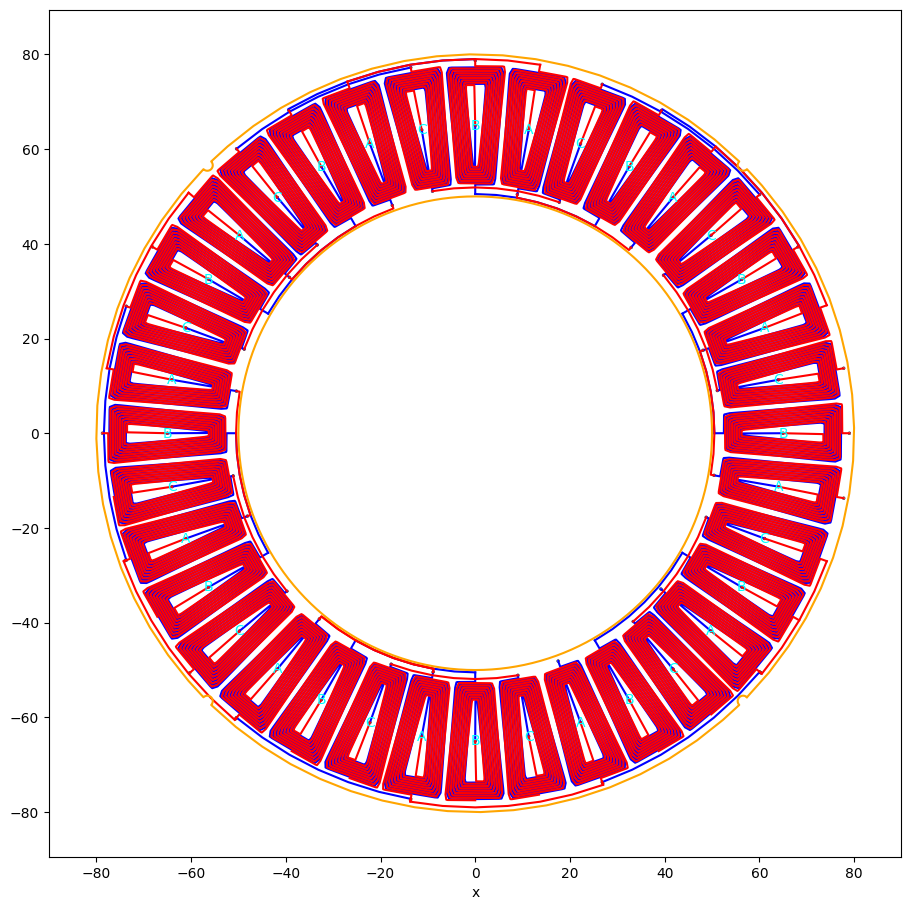

In [20]:
# plot the json
plot_json(json_result)